In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Load CIFAR-10
(X_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

# Filter only 'airplane' class (class 0)
X_train = X_train[y_train.flatten() == 0]

# Normalize images to [-1, 1]
X_train = (X_train.astype('float32') - 127.5) / 127.5

# Create TensorFlow dataset
BUFFER_SIZE = 5000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (3,3), strides=(1,1), padding='same', use_bias=False, activation='tanh')
    ])
    return model


In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (4,4), strides=(2,2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (4,4), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                    cross_entropy(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
import time
from IPython.display import clear_output

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        # Corrected the indentation here
        plt.imshow(((predictions[i] * 127.5 + 127.5).numpy()).astype("uint8"))

        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    plt.show()


In [ ]:
def train(dataset, epochs):
    seed = tf.random.normal([16, 100])
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)

        clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        print(f'Time for epoch {epoch+1} is {time.time() - start:.2f} sec')


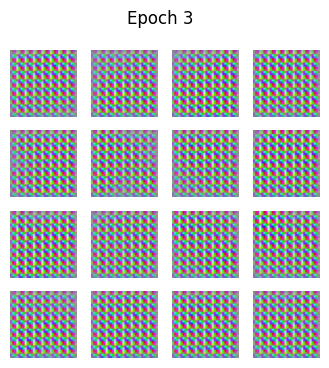

Time for epoch 3 is 95.12 sec


KeyboardInterrupt: 

In [ ]:
EPOCHS = 10
train(train_dataset, EPOCHS)
